In [1]:
import os, os.path
import cv2
import random
from sklearn import decomposition
import matplotlib.pyplot as plt
import numpy as np


nuetral_path = "../Lab1/Cohn-Kanade/neutral/"
happy_path = "../Lab1/Cohn-Kanade/happy/"
surprise_path = "../Lab1/Cohn-Kanade/surprise/"
disgust_path = "../Lab1/Cohn-Kanade/disgust/"


neutral_imgs = []
happy_imgs = []
surprise_imgs = []
disgust_imgs = []

images = os.listdir(nuetral_path)
for img_num, img in enumerate(images):
    neutral_imgs.append(cv2.cvtColor(cv2.imread(nuetral_path + '/' + img), cv2.COLOR_BGR2GRAY))

images = os.listdir(happy_path)
for img_num, img in enumerate(images):
    happy_imgs.append(cv2.cvtColor(cv2.imread(happy_path + '/' + img), cv2.COLOR_BGR2GRAY))

images = os.listdir(surprise_path)
for img_num, img in enumerate(images):
    surprise_imgs.append(cv2.cvtColor(cv2.imread(surprise_path + '/' + img), cv2.COLOR_BGR2GRAY))

images = os.listdir(disgust_path)
for img_num, img in enumerate(images):
    disgust_imgs.append(cv2.cvtColor(cv2.imread(disgust_path + '/' + img), cv2.COLOR_BGR2GRAY))

random.shuffle(neutral_imgs)
random.shuffle(happy_imgs)
random.shuffle(surprise_imgs)
random.shuffle(disgust_imgs)


X = neutral_imgs + happy_imgs + surprise_imgs + disgust_imgs
y = [-2]*len(neutral_imgs) + [-1]*len(happy_imgs) + [1]*len(surprise_imgs) + [2]*len(disgust_imgs)

X_train = neutral_imgs[:120] + happy_imgs[:60] + surprise_imgs[:60] + disgust_imgs[:30]
X_test = neutral_imgs[120:] + happy_imgs[60:] + surprise_imgs[60:] + disgust_imgs[30:]
y_train = [-2]*120 + [-1]*60 + [1]*60 + [2]*30
y_test = [-2]*(len(neutral_imgs)-120) + [-1]*(len(happy_imgs)-60) + [1]*(len(surprise_imgs)-60) + [2]*(len(disgust_imgs)-30)


twoD_to_vec = lambda mat: mat.reshape(-1).T
X_train_vectorized = list(map(twoD_to_vec, X_train))
X_test_vectorized = list(map(twoD_to_vec, X_test))


pca = decomposition.PCA(n_components=50)

X_train_pca = pca.fit_transform(X_train_vectorized)
X_test_pca = pca.transform(X_test_vectorized)

در قسمت بالا صرفا داده ها را مطابق خواسته لود کرده و با پی سی ای کاهش بعد داده ایم.

In [31]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from statistics import mean
import numpy as np

pca_cv = decomposition.PCA(n_components=50)


X = neutral_imgs + happy_imgs + surprise_imgs + disgust_imgs
X = list(map(twoD_to_vec, X))
y = [-2]*len(neutral_imgs) + [-1]*len(happy_imgs) + [1]*len(surprise_imgs) + [2]*len(disgust_imgs)
X_pca_cv = pca.fit_transform(X)
n = len(y)

C_list = range(5, 50, 2)
accuracy_list = []
cv_scores = []

Num_Folds = 5

for C in C_list: 
    for i in range(Num_Folds):
        svm = SVC(C=C)
        X_train_cv = list(X_pca_cv[0:int(i*n/Num_Folds) , :]) + list(X_pca_cv[int((i+1)*n/Num_Folds): , :])
        X_test_cv  = list(X_pca_cv[int(i*n/Num_Folds) : int((i+1)*n/Num_Folds)])
        y_train_cv = y[0 : int(i*n/Num_Folds)] + y[int((i+1)*n/Num_Folds) : ]
        y_test_cv  = y[int(i*n/Num_Folds) : int((i+1)*n/Num_Folds)] 

        svm.fit(np.array(X_train_cv), y_train_cv)
        y_pred_cv = svm.predict(np.array(X_test_cv))
        accuracy_list.append(accuracy_score(y_test_cv, y_pred_cv))

    cv_scores.append(mean(accuracy_list))
    accuracy_list.clear()

        
C_opt = C_list[cv_scores.index(max(cv_scores))]
print(F"Best C Value is {C_opt}")

Best C Value is 39


در سل بالا برای یک تعداد محتمل برای مقدار «سی» و با روش «کی فولد» با مقدار 5 مقدار بهینه «سی» را پیدا کرده ایم که برابر با 17 میباشد (البته در تلاش های مختلف مقادیر 13 و 17 و 35 دیده شد) میباشد.
دقت کنید که زمان اجرای سل بالا طولانی است و درصورتی که اجرای آن لزومی ندارد آن را اجرا نکنید در غیر اینصورت با آنکامنت کردن کد های بالا به اجرای آن و بررسی خروجی بپردازید.

In [32]:
from sklearn.metrics import classification_report

SVM_neu2oth = SVC(C=C_opt)  
SVM_hap2oth = SVC(C=C_opt)  
SVM_sup2oth = SVC(C=C_opt)  
################################################
y_train_neu2oth = [1]*120 + [0]*150
SVM_neu2oth.fit(X_train_pca, y_train_neu2oth)

y_train_hap2oth = [0]*120 + [1]*60 + [0]*90
SVM_hap2oth.fit(X_train_pca, y_train_hap2oth)

y_train_sup2oth = [0]*120 + [0]*60 + [1]*60 + [0]*30
SVM_sup2oth.fit(X_train_pca, y_train_sup2oth)

# print(SVM_sup2oth.decision_function(X_test_pca))
################################################
y_pred_neu2oth = SVM_neu2oth.predict(X_test_pca)
y_pred_hap2oth = SVM_hap2oth.predict(X_test_pca)
y_pred_sup2oth = SVM_sup2oth.predict(X_test_pca)
y_pred = []
for i in range(len(y_test)):
    if y_pred_neu2oth[i] == 1:
        y_pred.append(-2)
    elif y_pred_hap2oth[i] == 1:
        y_pred.append(-1)
    elif y_pred_sup2oth[i] == 1:
        y_pred.append(1)
    else:
        y_pred.append(2)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(report)


Accuracy: 0.7571428571428571
              precision    recall  f1-score   support

          -2       0.85      0.79      0.81        70
          -1       0.76      0.76      0.76        25
           1       1.00      0.71      0.83        28
           2       0.40      0.71      0.51        17

    accuracy                           0.76       140
   macro avg       0.75      0.74      0.73       140
weighted avg       0.81      0.76      0.77       140



در سل بالا، مطابق خواسته دستور کار، برای هر کلاس از داده و داده های سایر کلاس ها، کلسیفایر های جداگانه آموزش داده ایم. پس از آن با هر کدام از این کلسیفایر ها تصمیم گیری میان
اینکه این نمونه متعلق به «کلاس خاص فلان» است یا متعلق به «یکی از سایر کلاس ها» است را انجام داده ایم. دقت کنید که این تصمیم گیری را 
با تمام کلسیفایر ها انجام داده ایم و با توجه به نتیجه تمام این کلسیفایر ها توانسته ایم لیبل مناسب و نهایی آن نمونه را مشخص کنیم.

در ادامه نیز مطابق خواسته مساله، معیار های مختلفی از عملکرد مدل (که در واقع نتیجه حاصله از عملکرد همزمان چندین مدل دو کلاسه است) را نشان داده ایم مانند «پرسیشن» یا «ریکال» یا 
معیار «اف-وان اسکور» که در بالا مشهود است.

همچنین خطی که کامنت شده است را اگر آنکامنت کنید، میتوانید ضریب اطمینان لیبلی که هر مدل به نمونه وارده اساین میکند را متوجه شوید که این هم معیار خوبی از عملکرد تفکیک دادن مدل است.

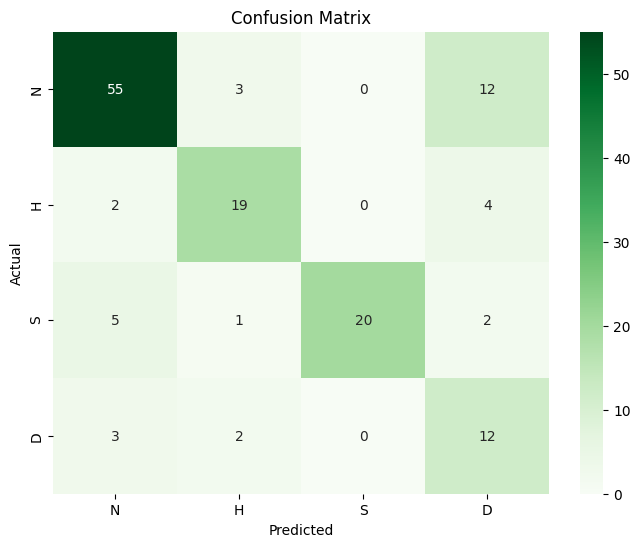

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greens', xticklabels="NHSD", yticklabels="NHSD")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


در این قسمت نیز، یک حالت تصویرسازی شده برای فهم بهتر عملکرد مدل را نشان داده ایم. در ماتریس فوق، میتوانید عملکرد مدل برای پیش بینی لیبل هر داده و لیبل واقعی آن را مشاهده کنید.
با استفاده از این ماتریس داده های خوبی قابل فهم است مثلا اینکه مدل نسبت به کدام کلاس دقت کمتر یا بیشتری دارد.

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid_rbf = {'C': [0.01, 0.1, 0.5, 1, 2, 3, 4, 5],
                  'gamma': [0.0001, 0.00002]}

svm_rbf = SVC(kernel='rbf')
grid_search_rbf = GridSearchCV(estimator=svm_rbf, param_grid=param_grid_rbf, cv=5, scoring='accuracy')
grid_search_rbf.fit(X_train_pca, y_train)

best_C_rbf = grid_search_rbf.best_params_['C']
best_gamma_rbf = grid_search_rbf.best_params_['gamma']

param_grid_linear = {'C': [0.01, 0.1, 0.5, 1, 2, 3, 4, 5]}

svm_linear = SVC(kernel='linear')
grid_search_linear = GridSearchCV(estimator=svm_linear, param_grid=param_grid_linear, cv=5, scoring='accuracy')
grid_search_linear.fit(X_train_pca, y_train)

best_C_linear = grid_search_linear.best_params_['C']

print("Best hyperparameters for RBF Kernel:")
print(f"Best C: {best_C_rbf}, Best gamma: {best_gamma_rbf}")

print("\nBest hyperparameters for Linear Kernel:")
print(f"Best C: {best_C_linear}")


Best hyperparameters for RBF Kernel:
Best C: 0.01, Best gamma: 0.0001

Best hyperparameters for Linear Kernel:
Best C: 0.01


In [46]:
from sklearn.metrics import accuracy_score, classification_report

svm_rbf_best = SVC(kernel='rbf', C=best_C_rbf, gamma=best_gamma_rbf)
svm_rbf_best.fit(X_train_pca, y_train)
y_pred_rbf = svm_rbf_best.predict(X_test_pca)

accuracy_rbf = accuracy_score(y_test, y_pred_rbf)
report_rbf = classification_report(y_test, y_pred_rbf)

svm_linear_best = SVC(kernel='linear', C=best_C_linear)
svm_linear_best.fit(X_train_pca, y_train)
y_pred_linear = svm_linear_best.predict(X_test_pca)

accuracy_linear = accuracy_score(y_test, y_pred_linear)
report_linear = classification_report(y_test, y_pred_linear)

print("Results for RBF Kernel:")
print(f"Accuracy: {accuracy_rbf}")
print(report_rbf)


print("\nResults for Linear Kernel:")
print(f"Accuracy: {accuracy_linear}")
print(report_linear)


Results for RBF Kernel:
Accuracy: 0.5
              precision    recall  f1-score   support

          -2       0.50      1.00      0.67        70
          -1       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        28
           2       0.00      0.00      0.00        17

    accuracy                           0.50       140
   macro avg       0.12      0.25      0.17       140
weighted avg       0.25      0.50      0.33       140


Results for Linear Kernel:
Accuracy: 0.7928571428571428
              precision    recall  f1-score   support

          -2       0.78      0.91      0.84        70
          -1       0.81      0.68      0.74        25
           1       1.00      0.86      0.92        28
           2       0.46      0.35      0.40        17

    accuracy                           0.79       140
   macro avg       0.76      0.70      0.73       140
weighted avg       0.79      0.79      0.79       140



c:\Users\padidar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\padidar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\padidar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera